# Notebook 02 — FFT-Based Carpet Severity Metric (Part 1)

This notebook implements the carpet severity metric required by the challenge.

Challenge-aligned definition:
- Carpet: spectral peaks randomly close to each other (irregular spacing)
- Non-carpet: regularly spaced peaks (harmonic-like spacing)

Why FFT (vs Welch PSD):
Welch PSD is a stable diagnostic representation (Notebook 01), but it can smooth peak microstructure.
Because the challenge requires analysis of peak spacing regularity, we use FFT magnitude to preserve
peak positions and spacing information.

Deliverables from this notebook:
1. Peak extraction in a target frequency band (>= 1000 Hz).
2. Metrics that quantify irregular peak spacing and peak clustering.
3. A carpet severity score per sample.
4. Identification of the sample with the worst carpet symptom.


## 1. Setup and Data Access

This section imports utilities from the repository and defines global parameters used consistently across all samples.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from tractian_cm.io.loaders import load_part1_wave_csv


In [2]:
def fft_magnitude_single_sided(x: np.ndarray, fs: float) -> tuple[np.ndarray, np.ndarray]:
    """
    EN: Compute single-sided FFT magnitude with Hann window to reduce leakage.
    EN: Returns frequency axis (Hz) and magnitude spectrum (linear).
    """
    x = np.asarray(x, dtype=float)
    n = x.size

    # EN: Detrend by removing mean (DC)
    x = x - np.mean(x)

    # EN: Apply Hann window
    w = np.hanning(n)
    xw = x * w

    # EN: rFFT -> single-sided spectrum
    X = np.fft.rfft(xw)
    f = np.fft.rfftfreq(n, d=1.0 / fs)

    # EN: Magnitude normalization (relative comparison; not absolute calibration)
    mag = np.abs(X) / (np.sum(w) / 2.0)

    return f, mag


## 2. FFT Magnitude Spectrum (Single-Sided)

We compute the single-sided FFT magnitude spectrum to preserve peak microstructure.

Key choices:
- Use a window (Hann) to reduce leakage.
- Use amplitude normalization only for comparability (absolute scale is not required).
- Focus on frequencies >= 1000 Hz as specified by the challenge.


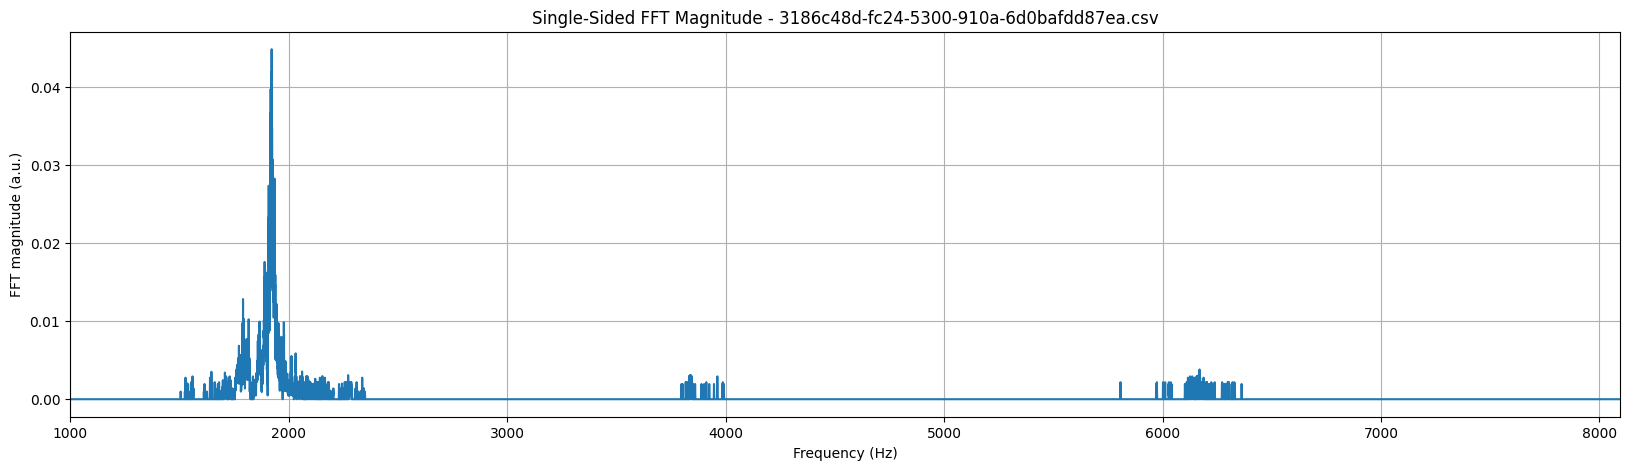

In [6]:
p = Path("../data/part_1/3186c48d-fc24-5300-910a-6d0bafdd87ea.csv")

wave, fs = load_part1_wave_csv(p)
x = np.asarray(wave.signal, dtype=float)

f, mag = fft_magnitude_single_sided(x, fs)

band = f >= 1000.0
plt.figure(figsize=(20,5))
plt.plot(f[band], mag[band])
plt.xlim(1000, f.max())
plt.xlabel("Frequency (Hz)")
plt.ylabel("FFT magnitude (a.u.)")
plt.title(f"Single-Sided FFT Magnitude - {p.name}")
plt.grid()
plt.show()


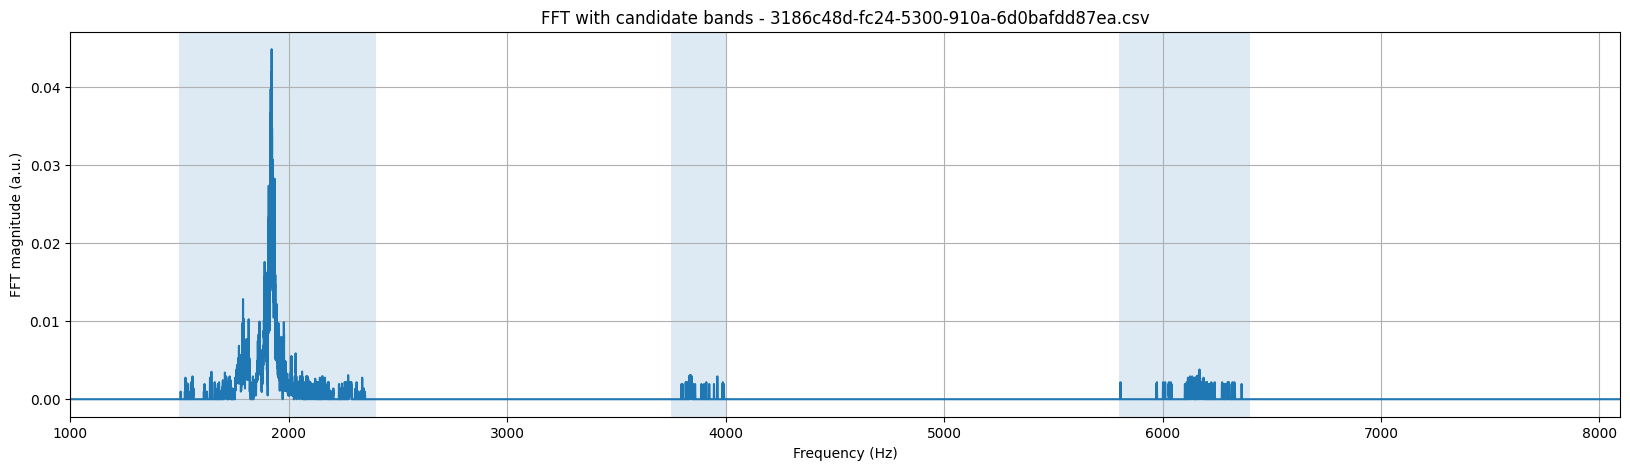

In [20]:
bands = [
    (1500, 2400),
    (3750, 4000),
    (5800, 6400),
]

plt.figure(figsize=(20,5))
plt.plot(f[band], mag[band])
for a,b in bands:
    plt.axvspan(a, b, alpha=0.15)
plt.xlim(1000, f.max())
plt.xlabel("Frequency (Hz)")
plt.ylabel("FFT magnitude (a.u.)")
plt.grid()
plt.title(f"FFT with candidate bands - {p.name}")
plt.show()


## 3. Peak Extraction

We extract peaks from the FFT magnitude spectrum within the analysis band.

Peak detection must be robust to different global amplitudes across samples, so thresholds are defined relative to a local / global baseline (e.g., median + k * MAD).


In [22]:
from scipy.signal import find_peaks

def mad(x: np.ndarray) -> float:
    """EN: Median Absolute Deviation (robust scale estimator)."""
    m = np.median(x)
    return float(np.median(np.abs(x - m)))

def extract_peaks_in_band(f: np.ndarray, mag: np.ndarray, fmin: float, fmax: float,
                          k: float = 6.0, min_distance_hz: float = 5.0):
    """
    EN: Extract peaks using robust thresholding in a frequency band.
    Returns peak frequencies (Hz) and peak magnitudes.
    """
    sel = (f >= fmin) & (f <= fmax)
    fb = f[sel]
    xb = mag[sel]

    scale = mad(xb)
    thr = np.median(xb) + k * scale

    df = float(np.median(np.diff(fb)))
    min_dist_bins = max(1, int(round(min_distance_hz / df)))

    peaks, props = find_peaks(xb, height=thr, distance=min_dist_bins)
    fpk = fb[peaks]
    mpk = xb[peaks]
    return fpk, mpk, thr


## 4. Metrics for Carpet vs Non-Carpet

We propose and compare metrics designed to differentiate:
- Regularly spaced peaks (harmonic-like): low variability in peak-to-peak spacing
- Irregularly clustered peaks (carpet-like): high variability + high local density

Candidate metrics:
1) Spacing variability: CV of Δf between consecutive peak frequencies
2) Local peak density: peaks per kHz (or peaks per window)
3) Periodicity penalty: strength of periodic spacing (optional, via autocorrelation of peak indicator sequence)


In [23]:
def spacing_cv(fpk: np.ndarray) -> float:
    """EN: Coefficient of variation of consecutive peak spacings."""
    if fpk.size < 3:
        return float("nan")
    df = np.diff(fpk)
    mu = float(np.mean(df))
    if mu == 0:
        return float("nan")
    return float(np.std(df) / mu)

def peak_density(fpk: np.ndarray, fmin: float, fmax: float) -> float:
    """EN: Peaks per kHz."""
    bw_khz = (fmax - fmin) / 1000.0
    return float(fpk.size / bw_khz) if bw_khz > 0 else float("nan")

def peak_dominance_ratio(mpk: np.ndarray) -> float:
    """EN: Peak dominance in linear magnitude."""
    if mpk.size == 0:
        return float("nan")
    med = float(np.median(mpk))
    return float(np.max(mpk) / (med + 1e-12))


## 5. Carpet Severity Score

We define a severity score that increases with:
- Peak density (more peaks per band)
- Spacing irregularity (higher CV of Δf)
and is reduced when the spectrum is dominated by one or a few peaks (peak dominance filter).

**Interpretation:
Higher severity score indicates stronger carpet-like behavior.**


We then compute the score per sample and rank samples to identify the worst carpet symptom.


In [24]:
for (a,b) in bands:
    fpk, mpk, thr = extract_peaks_in_band(f, mag, a, b, k=6.0, min_distance_hz=5.0)
    dens = peak_density(fpk, a, b)
    cv = spacing_cv(fpk)
    dom = peak_dominance_ratio(mpk)
    print(f"Band {a}-{b} Hz | peaks={len(fpk)} | density={dens:.1f}/kHz | spacing_CV={cv:.2f} | dominance={dom:.2f} | thr={thr:.4f}")


Band 1500-2400 Hz | peaks=26 | density=28.9/kHz | spacing_CV=0.80 | dominance=4.57 | thr=0.0048
Band 3750-4000 Hz | peaks=15 | density=60.0/kHz | spacing_CV=0.54 | dominance=1.58 | thr=0.0000
Band 5800-6400 Hz | peaks=34 | density=56.7/kHz | spacing_CV=1.73 | dominance=1.75 | thr=0.0000


### 5.1 Dynamic Peak Clustering (Gap-Based)

To avoid relying on fixed band widths, we form candidate carpet regions directly from FFT peak positions.

Approach:
- Extract peaks in the analysis band (>= 1000 Hz).
- Sort peak frequencies.
- Start a cluster and keep adding peaks while consecutive peak gaps remain below `gap_max_hz`.
- Each cluster defines a dynamic band: [min(f_peak), max(f_peak)].

This operationalizes the challenge definition of "peaks randomly close to each other" using a physically interpretable proximity threshold (`gap_max_hz`).


In [25]:
from dataclasses import dataclass

@dataclass(frozen=True)
class PeakCluster:
    """EN: Represents a cluster of FFT peaks within a dynamic frequency band."""
    f_start_hz: float
    f_end_hz: float
    f_peaks_hz: np.ndarray
    m_peaks: np.ndarray

def cluster_peaks_by_gap(
    fpk: np.ndarray,
    mpk: np.ndarray,
    gap_max_hz: float = 25.0,
    min_peaks: int = 8,
) -> list[PeakCluster]:
    """
    EN: Cluster peaks by grouping consecutive peaks whose spacing is <= gap_max_hz.
    EN: Returns clusters that contain at least min_peaks peaks.
    """
    fpk = np.asarray(fpk, dtype=float)
    mpk = np.asarray(mpk, dtype=float)

    if fpk.size == 0:
        return []

    # EN: sort by frequency
    order = np.argsort(fpk)
    fpk = fpk[order]
    mpk = mpk[order]

    clusters: list[PeakCluster] = []
    start = 0

    for i in range(1, fpk.size):
        if (fpk[i] - fpk[i - 1]) > gap_max_hz:
            # EN: finalize current cluster [start, i)
            if (i - start) >= min_peaks:
                f_seg = fpk[start:i]
                m_seg = mpk[start:i]
                clusters.append(
                    PeakCluster(
                        f_start_hz=float(f_seg[0]),
                        f_end_hz=float(f_seg[-1]),
                        f_peaks_hz=f_seg,
                        m_peaks=m_seg,
                    )
                )
            start = i

    # EN: finalize last cluster [start, end)
    if (fpk.size - start) >= min_peaks:
        f_seg = fpk[start:]
        m_seg = mpk[start:]
        clusters.append(
            PeakCluster(
                f_start_hz=float(f_seg[0]),
                f_end_hz=float(f_seg[-1]),
                f_peaks_hz=f_seg,
                m_peaks=m_seg,
            )
        )

    return clusters


### 5.2 Cluster Scoring and Sample Severity Aggregation

For each peak cluster we compute:

- Peak density: peaks per kHz inside the dynamic band
- Spacing irregularity: CV of consecutive peak spacings (Δf)
- Peak dominance: ratio between max and median peak magnitude

A carpet severity score should:
- Increase with density and spacing irregularity
- Decrease when a cluster is dominated by a few peaks

We compute a per-cluster score and aggregate per sample as the sum of the top-k cluster scores.


In [31]:
def cluster_metrics_and_score(cluster: PeakCluster) -> dict:
    """
    EN: Compute metrics and a severity score for a peak cluster.
    """
    fpk = cluster.f_peaks_hz
    mpk = cluster.m_peaks

    width_hz = float(cluster.f_end_hz - cluster.f_start_hz)
    width_khz = width_hz / 1000.0 if width_hz > 0 else np.nan

    # EN: Peak density (peaks per kHz)
    density = float(fpk.size / width_khz) if np.isfinite(width_khz) and width_khz > 0 else float("nan")

    # EN: Spacing CV over consecutive peak gaps
    if fpk.size >= 3:
        df = np.diff(fpk)
        mu = float(np.mean(df))
        spacing_cv_val = float(np.std(df) / mu) if mu > 0 else float("nan")
    else:
        spacing_cv_val = float("nan")

    # EN: Peak dominance ratio in linear magnitude
    if mpk.size:
        med = float(np.median(mpk))
        dominance = float(np.max(mpk) / (med + 1e-12))
    else:
        dominance = float("nan")

    # EN: Interpretable severity score:
    # EN: density ↑, spacing irregularity ↑, dominance ↓
    score = (
        float(density * spacing_cv_val / (dominance + 1e-12))
        if np.isfinite(density) and np.isfinite(spacing_cv_val) and np.isfinite(dominance)
        else float("nan")
    )

    return {
        "f_start_hz": cluster.f_start_hz,
        "f_end_hz": cluster.f_end_hz,
        "n_peaks": int(fpk.size),
        "width_hz": width_hz,
        "density_per_khz": density,
        "spacing_cv": spacing_cv_val,
        "dominance": dominance,
        "score": score,
    }


def sample_severity_from_clusters(cluster_scores: list[dict], top_k: int = 2) -> float:
    """
    EN: Aggregate severity across clusters as the sum of top-k cluster scores.
    """
    scores = [d["score"] for d in cluster_scores if np.isfinite(d["score"])]
    if not scores:
        return 0.0
    scores_sorted = sorted(scores, reverse=True)
    return float(np.sum(scores_sorted[:top_k]))


def plot_fft_with_clusters(
    f: np.ndarray,
    mag: np.ndarray,
    clusters: list[PeakCluster],
    fmin: float = 1000.0,
    fmax: float | None = None,
    title: str | None = None,
) -> None:
    """
    EN: Plot FFT magnitude and overlay shaded cluster regions and peak markers.
    """
    f = np.asarray(f, dtype=float)
    mag = np.asarray(mag, dtype=float)

    if fmax is None:
        fmax = float(f.max())

    sel = (f >= fmin) & (f <= fmax)
    fp = f[sel]
    mp = mag[sel]

    plt.figure(figsize=(20,5))
    plt.plot(fp, mp)

    # EN: overlay cluster bands and their peaks
    for c in clusters:
        a, b = c.f_start_hz, c.f_end_hz
        if b < fmin or a > fmax:
            continue
        plt.axvspan(max(a, fmin), min(b, fmax), alpha=0.15)
        plt.scatter(c.f_peaks_hz, c.m_peaks, s=12)

    plt.xlim(fmin, fmax)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("FFT magnitude (a.u.)")
    plt.title(title or "FFT magnitude with clustered peak regions")
    plt.show()


File: 3186c48d-fc24-5300-910a-6d0bafdd87ea.csv | fs=16188.0 | peaks=147 | clusters=5 | sample_score(top2)=105.421
  C1: 6273.0-6328.9 Hz | n=8 | dens=143.3/kHz | cv=0.45 | dom=1.00 | score=64.44
  C2: 3798.5-3860.8 Hz | n=8 | dens=128.5/kHz | cv=0.48 | dom=1.49 | score=40.98
  C3: 2231.0-2345.1 Hz | n=13 | dens=113.9/kHz | cv=0.47 | dom=1.53 | score=34.62
  C4: 6093.2-6239.0 Hz | n=20 | dens=137.2/kHz | cv=0.25 | dom=1.75 | score=19.32
  C5: 1615.4-2205.3 Hz | n=78 | dens=132.2/kHz | cv=0.35 | dom=15.32 | score=3.06


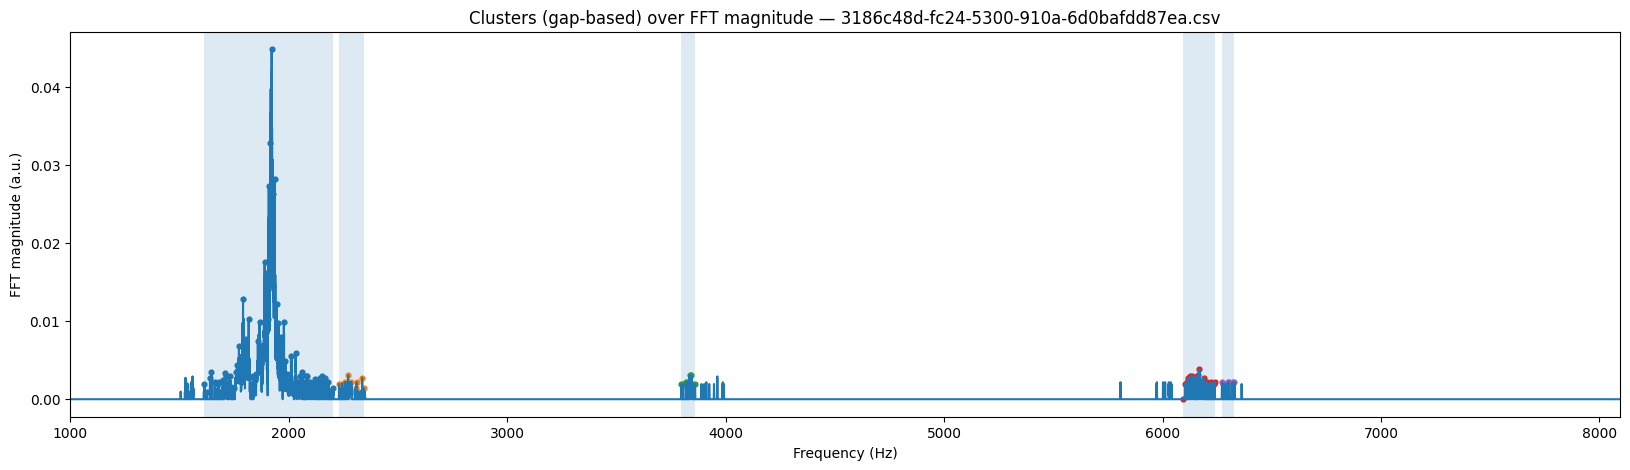

In [32]:
# --- Apply to a single candidate file (diagnostic before scaling to all samples) ---
p = Path("../data/part_1/3186c48d-fc24-5300-910a-6d0bafdd87ea.csv")
wave, fs = load_part1_wave_csv(p)
x = np.asarray(wave.signal, dtype=float)

f, mag = fft_magnitude_single_sided(x, fs)

# EN: Analyze only above 1000 Hz (challenge-aligned band)
mask = f >= 1000.0
fb = f[mask]
mb = mag[mask]

# EN: Robust peak extraction across the analysis band
fpk, mpk, thr = extract_peaks_in_band(
    fb, mb,
    fmin=1000.0,
    fmax=float(fb.max()),
    k=6.0,
    min_distance_hz=5.0
)

clusters = cluster_peaks_by_gap(fpk, mpk, gap_max_hz=25.0, min_peaks=8)
cluster_scores = [cluster_metrics_and_score(c) for c in clusters]
sample_score = sample_severity_from_clusters(cluster_scores, top_k=2)

print(f"File: {p.name} | fs={fs:.1f} | peaks={len(fpk)} | clusters={len(clusters)} | sample_score(top2)={sample_score:.3f}")
for i, d in enumerate(sorted(cluster_scores, key=lambda z: z['score'], reverse=True), start=1):
    print(
        f"  C{i}: {d['f_start_hz']:.1f}-{d['f_end_hz']:.1f} Hz | "
        f"n={d['n_peaks']} | dens={d['density_per_khz']:.1f}/kHz | "
        f"cv={d['spacing_cv']:.2f} | dom={d['dominance']:.2f} | score={d['score']:.2f}"
    )

plot_fft_with_clusters(
    f=fb,
    mag=mb,
    clusters=clusters,
    fmin=1000.0,
    fmax=float(fb.max()),
    title=f"Clusters (gap-based) over FFT magnitude — {p.name}",
)

## 6. Ranking and Diagnostics

We generate:
- A ranking table (sample, fs, RMS, score, number of peaks, spacing metrics)
- Diagnostic plots for top-ranked samples:
  - FFT magnitude with detected peaks annotated
  - Peak spacing histogram (or Δf sequence)
